## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, LabelEncoder

from scipy.stats import ttest_ind

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer 
from sklearn.metrics import matthews_corrcoef, plot_confusion_matrix,accuracy_score,plot_roc_curve,auc, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier

from ipywidgets import IntSlider, interact

## Read in Dataset

In [2]:
# Train data
train = pd.read_csv('datasets/train.csv')
train.columns = train.columns.str.lower()    # Convert all heading to lower
train['date'] = pd.to_datetime(train['date'])    # Convert date to datetime
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    10506 non-null  datetime64[ns]
 1   address                 10506 non-null  object        
 2   species                 10506 non-null  object        
 3   block                   10506 non-null  int64         
 4   street                  10506 non-null  object        
 5   trap                    10506 non-null  object        
 6   addressnumberandstreet  10506 non-null  object        
 7   latitude                10506 non-null  float64       
 8   longitude               10506 non-null  float64       
 9   addressaccuracy         10506 non-null  int64         
 10  nummosquitos            10506 non-null  int64         
 11  wnvpresent              10506 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), ob

In [3]:
# Spray data
spray = pd.read_csv('datasets/spray.csv')
spray.columns = spray.columns.str.lower()    # Convert all heading to lower
spray['date'] = pd.to_datetime(spray['date'])    # Convert date to datetime
spray.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       14835 non-null  datetime64[ns]
 1   time       14251 non-null  object        
 2   latitude   14835 non-null  float64       
 3   longitude  14835 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 463.7+ KB


In [4]:
# Weather data
weather = pd.read_csv('datasets/weather.csv', na_values = ['M', '-', 'T'])
weather.columns = weather.columns.str.lower()    # Convert all heading to lower
weather['date'] = pd.to_datetime(weather['date'])    # Convert date to datetime
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station      2944 non-null   int64         
 1   date         2944 non-null   datetime64[ns]
 2   tmax         2944 non-null   int64         
 3   tmin         2944 non-null   int64         
 4   tavg         2933 non-null   float64       
 5   depart       1472 non-null   float64       
 6   dewpoint     2944 non-null   int64         
 7   wetbulb      2940 non-null   float64       
 8   heat         2933 non-null   float64       
 9   cool         2933 non-null   float64       
 10  sunrise      1472 non-null   float64       
 11  sunset       1472 non-null   float64       
 12  codesum      2944 non-null   object        
 13  depth        1472 non-null   float64       
 14  water1       0 non-null      float64       
 15  snowfall     1472 non-null   object        
 16  precip

### Null Hypothesis Testing on Weather Stations

In [5]:
weather[weather.station == 1].describe().T

,count,mean,std,min,25%,50%,75%,max
station,1472.0,1.000000,0.000000,1.00,1.00,1.00,1.00,1.00
tmax,1472.0,75.978940,11.503150,42.00,68.00,78.00,85.00,103.00
tmin,1472.0,56.730978,10.347907,29.00,49.00,58.00,65.00,82.00
tavg,1472.0,66.606658,10.511437,36.00,60.00,68.00,75.00,93.00
depart,1472.0,1.954484,6.841110,-17.00,-3.00,2.00,7.00,23.00
dewpoint,1472.0,53.377717,10.670263,22.00,46.00,54.00,61.25,75.00
wetbulb,1469.0,59.036079,9.323693,32.00,53.00,60.00,66.00,78.00
heat,1472.0,3.631114,6.133829,0.00,0.00,0.00,5.00,29.00
cool,1472.0,5.237772,5.899382,0.00,0.00,3.00,10.00,28.00
sunrise,1472.0,480.646739,65.344729,416.00,424.75,446.50,531.25,623.00


In [6]:
weather[weather.station == 2].describe().T

,count,mean,std,min,25%,50%,75%,max
station,1472.0,2.000000,0.000000,2.00,2.000,2.00,2.000,2.00
tmax,1472.0,76.353261,11.421482,41.00,69.000,78.00,85.000,104.00
tmin,1472.0,58.889946,10.306855,29.00,51.000,60.00,67.000,83.00
tavg,1461.0,67.878166,10.544762,36.00,61.000,70.00,76.000,94.00
depart,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dewpoint,1472.0,53.538043,10.683121,23.00,46.000,55.00,62.000,74.00
wetbulb,1471.0,59.585316,9.244710,33.00,53.000,61.00,67.000,77.00
heat,1461.0,3.181383,5.758789,0.00,0.000,0.00,4.000,29.00
cool,1461.0,6.059548,6.280641,0.00,0.000,5.00,11.000,29.00
sunrise,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data1, data2 = weather[weather.station == 1]['tmax'], weather[weather.station == 2]['tmax']

stat, p = ttest_ind(data1, data2)
print(f'stat={stat:.3}, p={p:.3}')
if p > 0.05:
    print('\nProbably the same distribution')
else:
    print('\nProbably different distributions')

stat=-0.886, p=0.376

Probably the same distribution


<span style = 'color:orange'>Remark:</span> We have statistically proven that there is no significant difference between the weather data from both stations. As such, we would be mapping the weather from station 1 to the trap locations to give us the corresponding weather info.

In [8]:
# Check and filter columns that are null
weather.isnull().sum()[weather.isnull().sum() !=0]

tavg             11
depart         1472
wetbulb           4
heat             11
cool             11
sunrise        1472
sunset         1472
depth          1472
water1         2944
snowfall       1472
preciptotal       2
stnpressure       4
sealevel          9
avgspeed          3
dtype: int64

In [9]:
#too many null values, missing from 1 station or otherwise no entry
weather.drop(columns=['depart','water1','depth','snowfall'], inplace = True, errors = 'ignore')

<span style = 'color:orange'>Remark:</span> We dropped the following due to:
- Snowfall & depth contains 3779 0 values, inclusion of the 4696 null values making them insignificant to our problem statment 
- depart is a derivatives from tempature. We will use heat and cool to measure tempature instead
- Water1 is not avaialbe from both stations. 

In [10]:
# removing '  T' from Preciptotal and changing type to float
weather['preciptotal'] = weather['preciptotal'].replace('  T', np.nan).astype('float')
weather.isnull().sum()[weather.isnull().sum() !=0]

tavg             11
wetbulb           4
heat             11
cool             11
sunrise        1472
sunset         1472
preciptotal     320
stnpressure       4
sealevel          9
avgspeed          3
dtype: int64

In [11]:
#weather.fillna(value = 0, inplace = True)

In [12]:
# 14 days for the mosquito to grow, therefore push 
# date to 14 days to see correlation
weather.set_index('date', inplace=True)

# Filter for station 1
weather = weather[weather['station'] == 1]

# columns that we are not shifting
do_not_shift = weather[['stnpressure', 'sealevel']].copy()


weather['station'] = weather['station'].shift(periods = 28)
weather[['stnpressure', 'sealevel']] = do_not_shift

#reset back index of weather data
weather.reset_index(inplace = True)
weather['date'] = pd.to_datetime(weather['date'])

<span style = 'color:orange'>Remark:</span> From outside research, we expect the lifespan of mosquito to be only 2 weeks. Hence we are doing a time index shift of 2 weeks to match our weather patterns to the number of mosquitos present.

## Exploratory Data Analysis / Feature Engineering

### Total Mosquitos

In [13]:
# From data descriptions, there will be a new entry if the number of mosquitos more than 50
# Find the sum of total mosquitos

# Create a unique column for identification
train['concat'] = train['species'].astype(str) + train['trap'].astype(str) + train['date'].astype(str)

# create a groupby
group = pd.DataFrame(train.groupby(['concat'])['nummosquitos'].sum())

# merge groupby dataframe back to train df
train = pd.merge(train, group, on='concat', how='inner')

# Checking
train[train['nummosquitos_x']>=50].head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,nummosquitos_x,wnvpresent,concat,nummosquitos_y
293,2007-07-11,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,50,0,CULEX PIPIENS/RESTUANST0862007-07-11,143
295,2007-07-11,"2200 West 113th Street, Chicago, IL 60643, USA",CULEX PIPIENS/RESTUANS,22,W 113TH ST,T086,"2200 W 113TH ST, Chicago, IL",41.688324,-87.676709,8,50,0,CULEX PIPIENS/RESTUANST0862007-07-11,143
350,2007-07-11,"3500 West 116th Street, Chicago, IL 60655, USA",CULEX PIPIENS/RESTUANS,35,W 116TH ST,T158,"3500 W 116TH ST, Chicago, IL",41.682587,-87.707973,9,50,0,CULEX PIPIENS/RESTUANST1582007-07-11,189
351,2007-07-11,"3500 West 116th Street, Chicago, IL 60655, USA",CULEX PIPIENS/RESTUANS,35,W 116TH ST,T158,"3500 W 116TH ST, Chicago, IL",41.682587,-87.707973,9,50,0,CULEX PIPIENS/RESTUANST1582007-07-11,189
353,2007-07-11,"3500 West 116th Street, Chicago, IL 60655, USA",CULEX PIPIENS/RESTUANS,35,W 116TH ST,T158,"3500 W 116TH ST, Chicago, IL",41.682587,-87.707973,9,50,0,CULEX PIPIENS/RESTUANST1582007-07-11,189


In [14]:
# Drop duplicate
train.drop_duplicates(subset= ['species', 'trap', 'date'], inplace=True)

# Drop the columns created and rename the column
train.drop(columns = ['concat', 'nummosquitos_x'], errors='ignore', inplace=True)
train.rename(columns = {'nummosquitos_y':'total_mosquitos'},inplace=True)

# Checking
train.shape

(8475, 12)

<span style = 'color:orange'>Remark:</span> This is to classify our traps so that we know which  traps are being affected by weathers predicted by which stations.

### Train_combine = train + weather data

In [15]:
train_combine = pd.merge(train,weather,on = ['date'], how = 'inner')
train_combine.head()

,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,addressaccuracy,...,cool,sunrise,sunset,codesum,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,9.0,421.0,1917.0,BR HZ,0.0,29.39,30.11,5.8,18,6.5
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,...,9.0,421.0,1917.0,BR HZ,0.0,29.39,30.11,5.8,18,6.5
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,...,9.0,421.0,1917.0,BR HZ,0.0,29.39,30.11,5.8,18,6.5
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,9.0,421.0,1917.0,BR HZ,0.0,29.39,30.11,5.8,18,6.5
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,...,9.0,421.0,1917.0,BR HZ,0.0,29.39,30.11,5.8,18,6.5


In [16]:
train_combine.shape

(8475, 29)

### Visualisation

In [17]:
# Create a visualized widget 

sliderx = IntSlider(min = 2, max = 4, description = 'DayofWeek')
slidery = IntSlider(min =2007, max = 2013, step = 2, description = 'Year')
sliderz = IntSlider(min = 0, max = 1, description = 'WnvPresent')
slideri = IntSlider(min = 5, max = 10, description = 'Month')

origin = [41.6, -88.0]              # lat/long of origin (lower left corner)
upperRight = [42.1, -87.5]          # lat/long of upper right corner

mapdata = np.loadtxt("datasets/mapdata_copyright_openstreetmap_contributors.txt")

intersection = [41.995, -87.933]  # co-ordinates of intersection of IL64 / IL50 according to Google Earth
intersection2 = [41.786, -87.752]

def plot_func(x,y,z,i):
    
    
    plt.figure(figsize = (15,15))
    
    plt.imshow(mapdata, cmap=plt.get_cmap('gray'), extent=[origin[1], upperRight[1], origin[0], upperRight[0]])

    plt.scatter(x=intersection[1], y=intersection[0], c='b', s=60, marker='s')
    
    plt.scatter(x=intersection2[1], y=intersection2[0], c='b', s=60, marker='s')
    
    
    
    color = ['blue', 'red']
    plt.scatter(x='longitude',y='latitude',
                data = train_combine.loc[train_combine['wnvpresent'] == z]\
                .loc[train_combine['date'].dt.month == i]\
                .loc[train_combine['date'].dt.year == y],
                s=60,c = color[z])
    
    
    plt.scatter(x='longitude', y='latitude',
                data = spray.loc[spray['date'].dt.dayofweek == x ]\
                .loc[spray['date'].dt.month == i]\
                .loc[spray['date'].dt.year == y],
                c ='green', s=10, alpha = 0.2)
    plt.show()

interact(plot_func, x= sliderx, y = slidery, z = sliderz, i = slideri);

interactive(children=(IntSlider(value=2, description='DayofWeek', max=4, min=2), IntSlider(value=2007, descrip…

<span style = 'color:orange'>Remark:</span> We are observing the spatial relationship between traps, sprays & WNVpresent across time.

### Distribution of wnvpresent

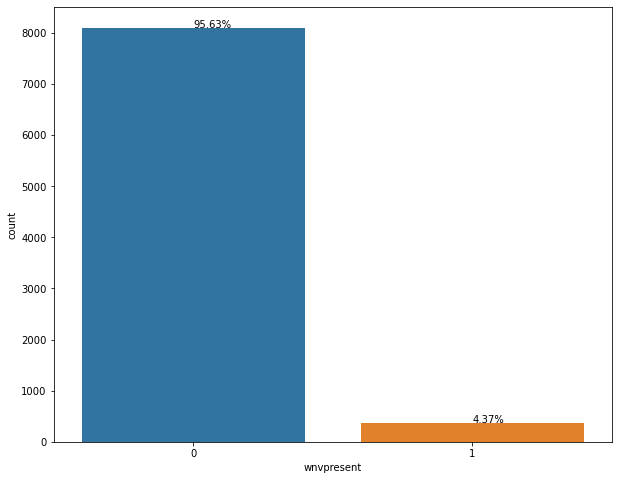

In [18]:
# First thing first. Let's check our target class distribution and see if the dataset is balanced or not.
fig,  ax = plt.subplots(1,1, figsize = (10, 8))
sns.countplot(x = 'wnvpresent', data = train, ax = ax)
for i in ax.patches:
    height = i.get_height()
    ax.text(i.get_x()+i.get_width()/2,height,'{:.2f}{}'.format(height/len(train)*100,'%'))
plt.show()

### Heat map of weather correlation

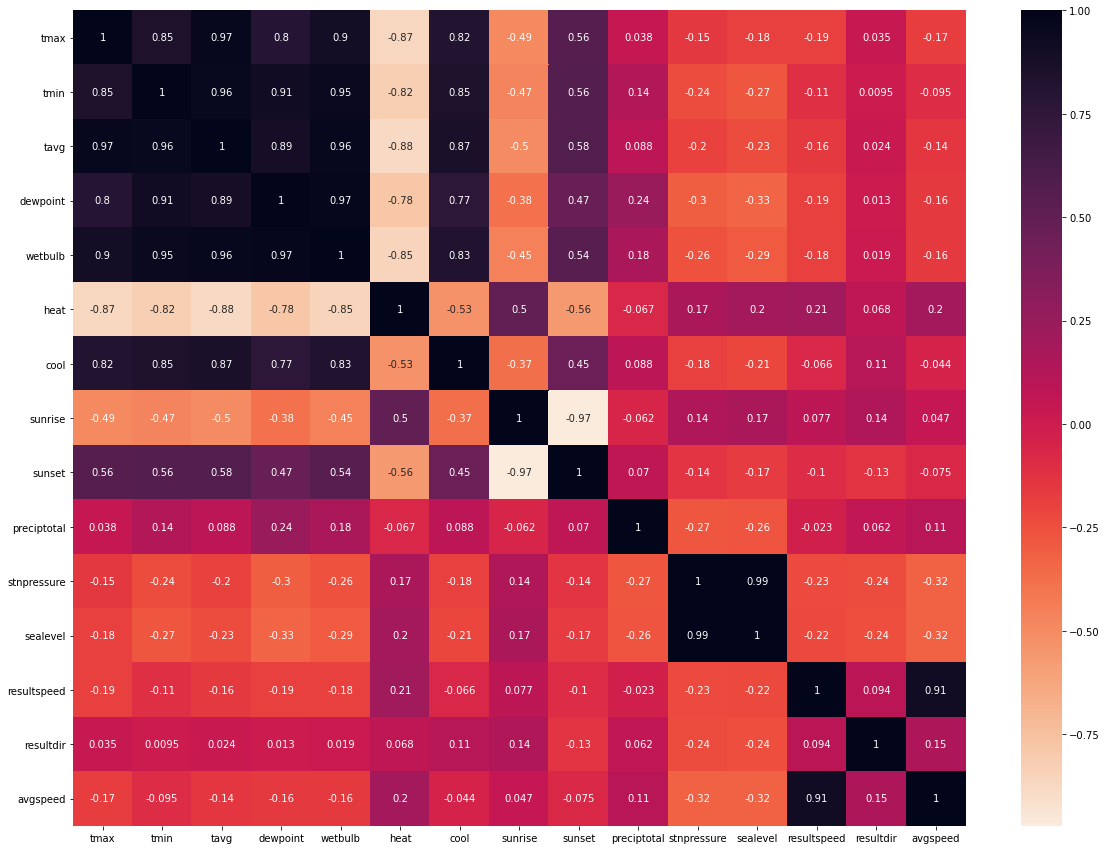

In [19]:
fig, ax = plt.subplots(1,1, figsize=(20,15))
#sns.color_palette("rocket_r", as_cmap=True)
sns.heatmap(weather.drop(columns='station').corr(), annot=True, cmap="rocket_r" ,ax = ax)
plt.show()

### Combo Chart of Species with wnvpresent

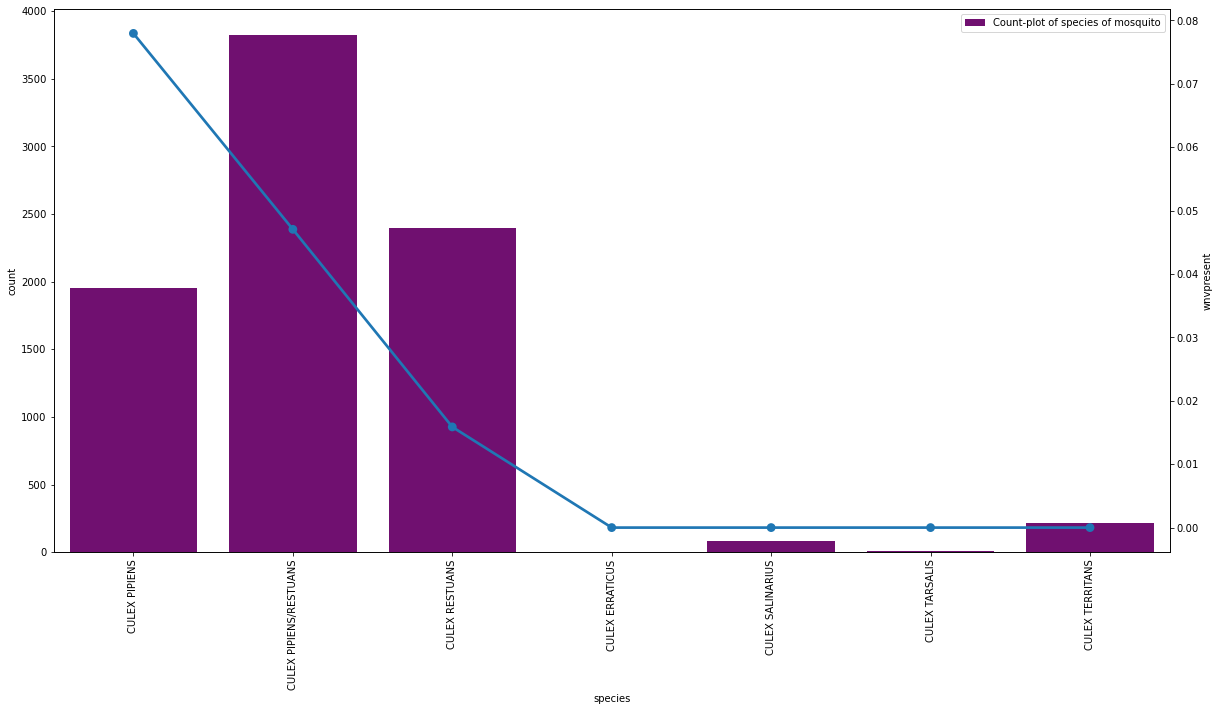

In [20]:
# Identifying Mosquito Species that are the most likely carriers of Virus.
tmp = pd.crosstab(train['species'],train['wnvpresent'],normalize='index')
tmp.reset_index(drop=True)
tmp.columns = ['wnvabsent','wnvpresent']
fig,ax = plt.subplots(1,1, figsize = (20, 10))

g = sns.countplot(x = 'species', 
                  data = train,
                  ax=ax, 
                  order = tmp.sort_values(by = 'wnvpresent', ascending = False).index, 
                  color = 'purple',
                  label = 'Count-plot of species of mosquito')

ax.tick_params(axis='x',rotation=90)

g2 = g.twinx()

sns.pointplot(x = tmp.index,
              y = 'wnvpresent', 
              data = tmp ,
              ax=g2, 
              order = tmp.sort_values(by = 'wnvpresent', ascending = False).index,
              label = 'presences of wnvpresent')

# Combine handles & labels from 2 subplots
handles, labels = [(a + b) for a, b in zip(g.get_legend_handles_labels(), g2.get_legend_handles_labels())]

plt.legend(handles, labels)
plt.show()

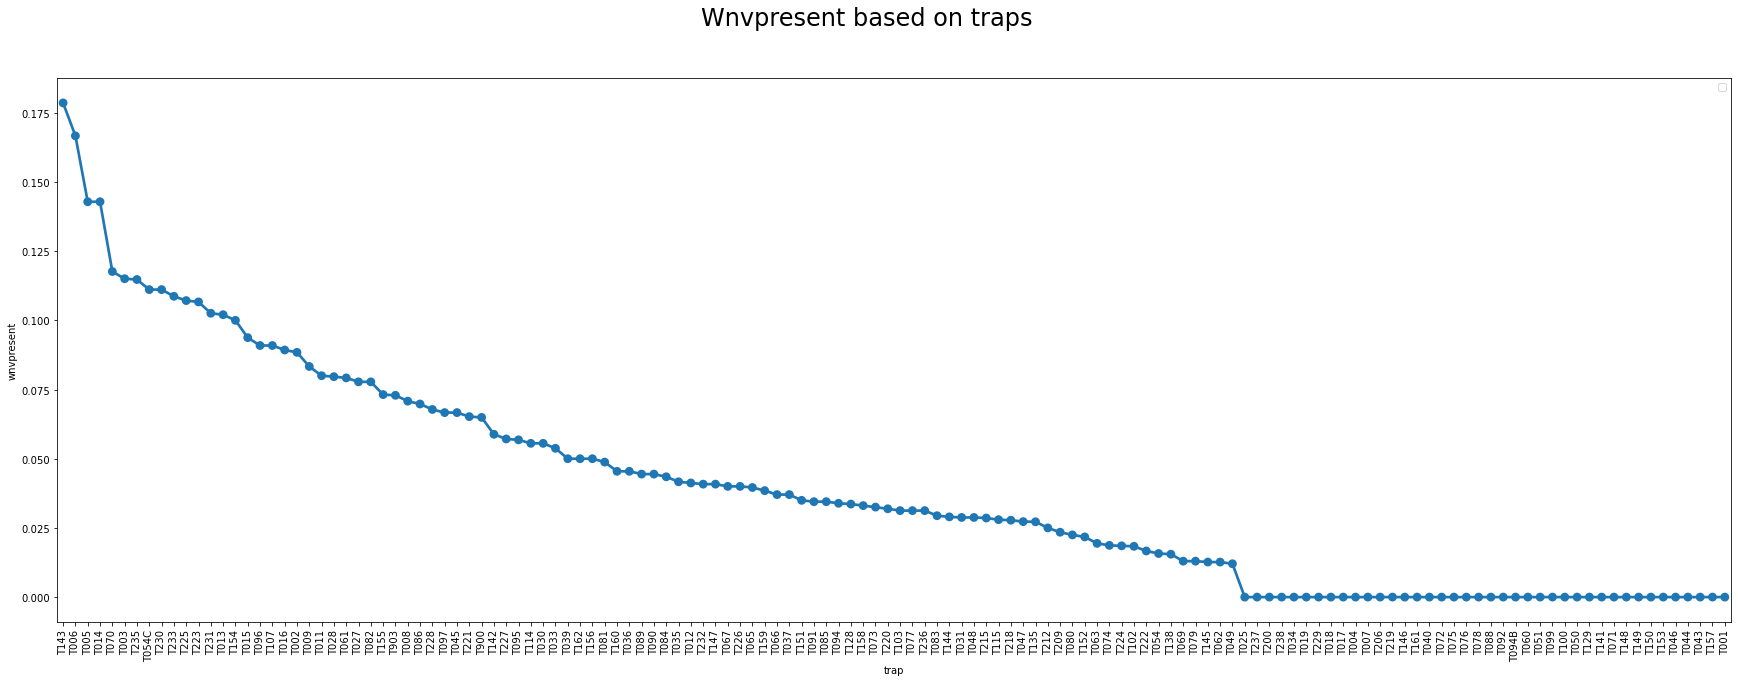

In [21]:
# Identifying Mosquito Species that are the most likely carriers of Virus.
tmp = pd.crosstab(train['trap'],train['wnvpresent'],normalize='index')
tmp.reset_index(drop=True)
tmp.columns = ['wnvabsent','wnvpresent']
fig,ax = plt.subplots(1,1, figsize = (30, 10))

ax.tick_params(axis='x',rotation=90)

sns.pointplot(x = tmp.index,
              y = 'wnvpresent', 
              data = tmp ,
              ax=ax, 
              order = tmp.sort_values(by = 'wnvpresent', ascending = False).index,
              label = 'presences of wnvpresent')

# Combine handles & labels from 2 subplots
handles, labels = ax.get_legend_handles_labels()

plt.legend(handles, labels)
plt.suptitle('Wnvpresent based on traps', fontsize=24)
plt.show()

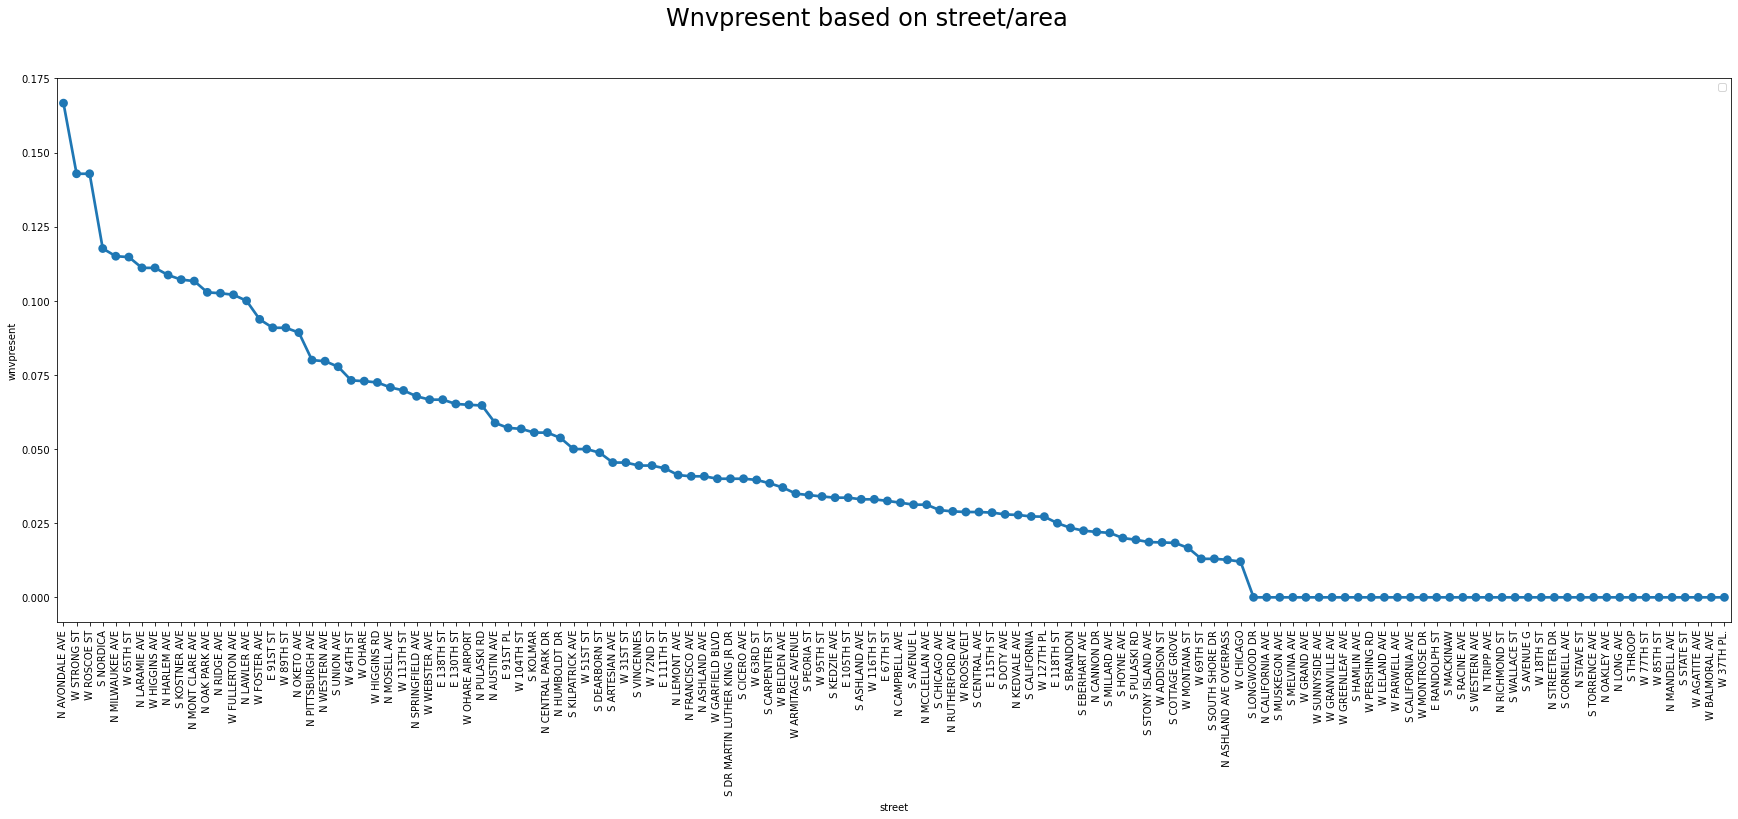

In [22]:
# Identifying Mosquito Species that are the most likely carriers of Virus.
tmp = pd.crosstab(train['street'],train['wnvpresent'],normalize='index')
tmp.reset_index(drop=True)
tmp.columns = ['wnvabsent','wnvpresent']
fig,ax = plt.subplots(1,1, figsize = (30, 10))

ax.tick_params(axis='x',rotation=90)

sns.pointplot(x = tmp.index,
              y = 'wnvpresent', 
              data = tmp ,
              ax=ax, 
              order = tmp.sort_values(by = 'wnvpresent', ascending = False).index,
              label = 'presences of wnvpresent')

# Combine handles & labels from 2 subplots
handles, labels = ax.get_legend_handles_labels()

plt.legend(handles, labels)
plt.suptitle('Wnvpresent based on street/area', fontsize=24)
plt.show()

### Data Cleaning for train_combine

In [23]:
train_clean = train_combine.copy()

In [24]:
# based on data description, drop column unessacary data with majority of null
train_clean.drop(columns=['address', 'block', 'addressnumberandstreet', 'addressaccuracy'],inplace=True, errors='ignore')

<span style = 'color:orange'>Remark:</span> We dropped the aboves as they are not providing significant information to our model.

In [25]:
# function that change time to seconds
def changetime(x):
    try:
        x = str(int(x))
        x1 = int(x[0])*60*60
        x2 = int(x[1:])*60
        x = x1 + x2
        return x
    except:
        return x

In [26]:
train_clean['sunrise'] = train_clean['sunrise'].map(lambda x: changetime(x)) # make changes on sunrise 
train_clean['sunset'] = train_clean['sunset'].map(lambda x: changetime(x))    # make changes on sunset

In [27]:
# fillna for sunset/sunrise with mean
mean_sunset = (train_clean['sunset'].loc[train_clean['sunset'].notnull()].sum()/len(train_clean[train_clean['sunset'].notnull()]))
mean_sunrise = (train_clean['sunrise'].loc[train_clean['sunrise'].notnull()].sum()/len(train_clean[train_clean['sunrise'].notnull()]))

train_clean['sunrise'].fillna(round(mean_sunrise), inplace = True)
train_clean['sunset'].fillna(round(mean_sunset), inplace = True)

In [28]:
# make sunset - sunrise = nighttime
train_clean['nighttime'] = train_clean['sunset'] - train_clean['sunrise']
train_clean['nighttime'] = train_clean['nighttime'].map(lambda x: 24 - round(x/3600))  # round it to be only hour

In [29]:
train_clean['nighttime'].value_counts()

12    3397
14    1694
13    1235
16     984
15     848
17     317
Name: nighttime, dtype: int64

In [30]:
train_clean[['sunset','sunrise','nighttime']].head()

,sunset,sunrise,nighttime
0,58620,15660,12
1,58620,15660,12
2,58620,15660,12
3,58620,15660,12
4,58620,15660,12


In [31]:
# after convert to nighttime, drop sunset and sunrise
train_clean.drop(columns=['sunrise','sunset'],inplace=True, errors='ignore')

In [32]:
# Check all the datatype
train_clean.dtypes

date               datetime64[ns]
species                    object
street                     object
trap                       object
latitude                  float64
longitude                 float64
wnvpresent                  int64
total_mosquitos             int64
station                   float64
tmax                        int64
tmin                        int64
tavg                      float64
dewpoint                    int64
wetbulb                   float64
heat                      float64
cool                      float64
codesum                    object
preciptotal               float64
stnpressure               float64
sealevel                  float64
resultspeed               float64
resultdir                   int64
avgspeed                  float64
nighttime                   int64
dtype: object

In [33]:
# fillna for stnpressure with the average pressure of each station
# Find station 1 mean station pressure
sp1 = train_clean['stnpressure'].mean()
train_clean['stnpressure'][train_clean['stnpressure'].isnull()] = sp1

C:\Users\Sim Yi\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [34]:
# fillna with mean
precip_mean = train_clean['preciptotal'].mean()
train_clean.loc[train_clean['preciptotal'].isnull(),'preciptotal'] = precip_mean

In [35]:
# fillna with mean
wetbulb_mean = train_clean['wetbulb'].mean()
train_clean.loc[train_clean['wetbulb'].isnull(),'wetbulb'] = wetbulb_mean

# Change type to interger
train_clean['wetbulb'] = train_clean['wetbulb'].astype(int)

In [36]:
# Check if there are still any null values
train_clean.isnull().sum()[train_clean.isnull().sum() !=0]

Series([], dtype: int64)

### EDA using cleaned dataset

In [37]:
train_clean.set_index('date',inplace=True)

In [38]:
train_clean_num = train_clean.select_dtypes(include=np.number)

In [39]:
train_clean_num 

,latitude,longitude,wnvpresent,total_mosquitos,station,tmax,tmin,tavg,dewpoint,wetbulb,heat,cool,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,nighttime
date,,,,,,,,,,,,,,,,,,,
2007-05-29,41.954690,-87.800991,0,1,1.0,88,60,74.0,58,65,0.0,9.0,0.0,29.39,30.11,5.8,18,6.5,12
2007-05-29,41.954690,-87.800991,0,1,1.0,88,60,74.0,58,65,0.0,9.0,0.0,29.39,30.11,5.8,18,6.5,12
2007-05-29,41.994991,-87.769279,0,1,1.0,88,60,74.0,58,65,0.0,9.0,0.0,29.39,30.11,5.8,18,6.5,12
2007-05-29,41.974089,-87.824812,0,1,1.0,88,60,74.0,58,65,0.0,9.0,0.0,29.39,30.11,5.8,18,6.5,12
2007-05-29,41.974089,-87.824812,0,4,1.0,88,60,74.0,58,65,0.0,9.0,0.0,29.39,30.11,5.8,18,6.5,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-09-26,41.763733,-87.742302,1,6,1.0,75,50,63.0,52,58,2.0,0.0,0.0,29.34,30.04,3.8,8,4.2,16
2013-09-26,41.987280,-87.666066,0,5,1.0,75,50,63.0,52,58,2.0,0.0,0.0,29.34,30.04,3.8,8,4.2,16
2013-09-26,41.912563,-87.668055,0,1,1.0,75,50,63.0,52,58,2.0,0.0,0.0,29.34,30.04,3.8,8,4.2,16


In [40]:
# Set X as a dataframe in order to plot
train_clean_y_plot = train_clean_y = train_clean[['wnvpresent']]
train_clean_X_plot = train_clean_num.drop(columns=['wnvpresent'], errors='ignore')

# Scale our features columns
# ss_clean = StandardScaler()
# train_clean_num_ss = ss_clean.fit_transform(train_clean_num)

# train_clean_num_df =pd.DataFrame(train_clean_num_ss, columns = train_clean_num.columns, index = train_clean_num.index)

In [41]:
def combi_plot(df_x, df_y, x_col_ls, y_col, agg_ls, year_ls, resample_mode, fs_tuple):
    
    y_num = len(year_ls)
    
    fig = plt.figure(figsize=fs_tuple)
    spec = gridspec.GridSpec(nrows=y_num, ncols=1, figure=fig, hspace = 0.2)


    for item in range(y_num):
        
        ax1 = fig.add_subplot(spec[item,0])
        
        # Resample the dataframe
        df_a = df_x.loc[df_x.index.year == year_ls[item]].resample(resample_mode)[x_col_ls].agg(agg_ls[0])
        df_b = df_y.loc[df_y.index.year == year_ls[item]].resample(resample_mode)[[y_col]].agg(agg_ls[1])
        
        # Combine the dataframe
        combined_df = pd.concat([df_a, df_b], axis=1)

        #wnvpresent plot creation
        ax1.set_title(f'{x_col_ls} vs Wnvpresent in {year_ls[item]}', fontsize=16)
        ax1.set_xlabel('Date', fontsize=16)
        ax1.set_ylabel('Count', fontsize=16)
        sns.lineplot(x=combined_df.index, y='wnvpresent', data=combined_df, palette='colorblind' ,linewidth=5, linestyle='--', label='wnvpresent', ax=ax1)
        ax1.tick_params(axis='y')
        ax1.get_legend().remove()

        #specify we want to share the same x-axis
        ax2 = ax1.twinx()
        

        #line plot creation
        ax2.set_ylabel('Feature scaled', fontsize=16)
        sns.lineplot(x='date', y='value', hue='variable', data=pd.melt(combined_df.reset_index().drop(columns=y_col), ['date']),
                           palette='tab10', style_order=interest_col, linewidth=2, ax=ax2)
        ax2.tick_params(axis='y', color='red')
        ax2.get_legend().remove()
        #ax2.set_ylim(-2,2)
        
        # Combine handles & labels from 2 subplots
        handles, labels = [(a + b) for a, b in zip(ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels())]
        
    # additional manual adjustment to the figure    
    fig.legend(handles, labels, loc='upper right', prop={'size': 15})
    fig.suptitle('Plot of Features vs Wnvpresent by years', fontsize= 25)
    plt.subplots_adjust(top=0.95)

    plt.show()

In [42]:
interest_col = ['tmax','wetbulb','cool', 'total_mosquitos', 'avgspeed', 'nighttime','preciptotal', 'stnpressure']

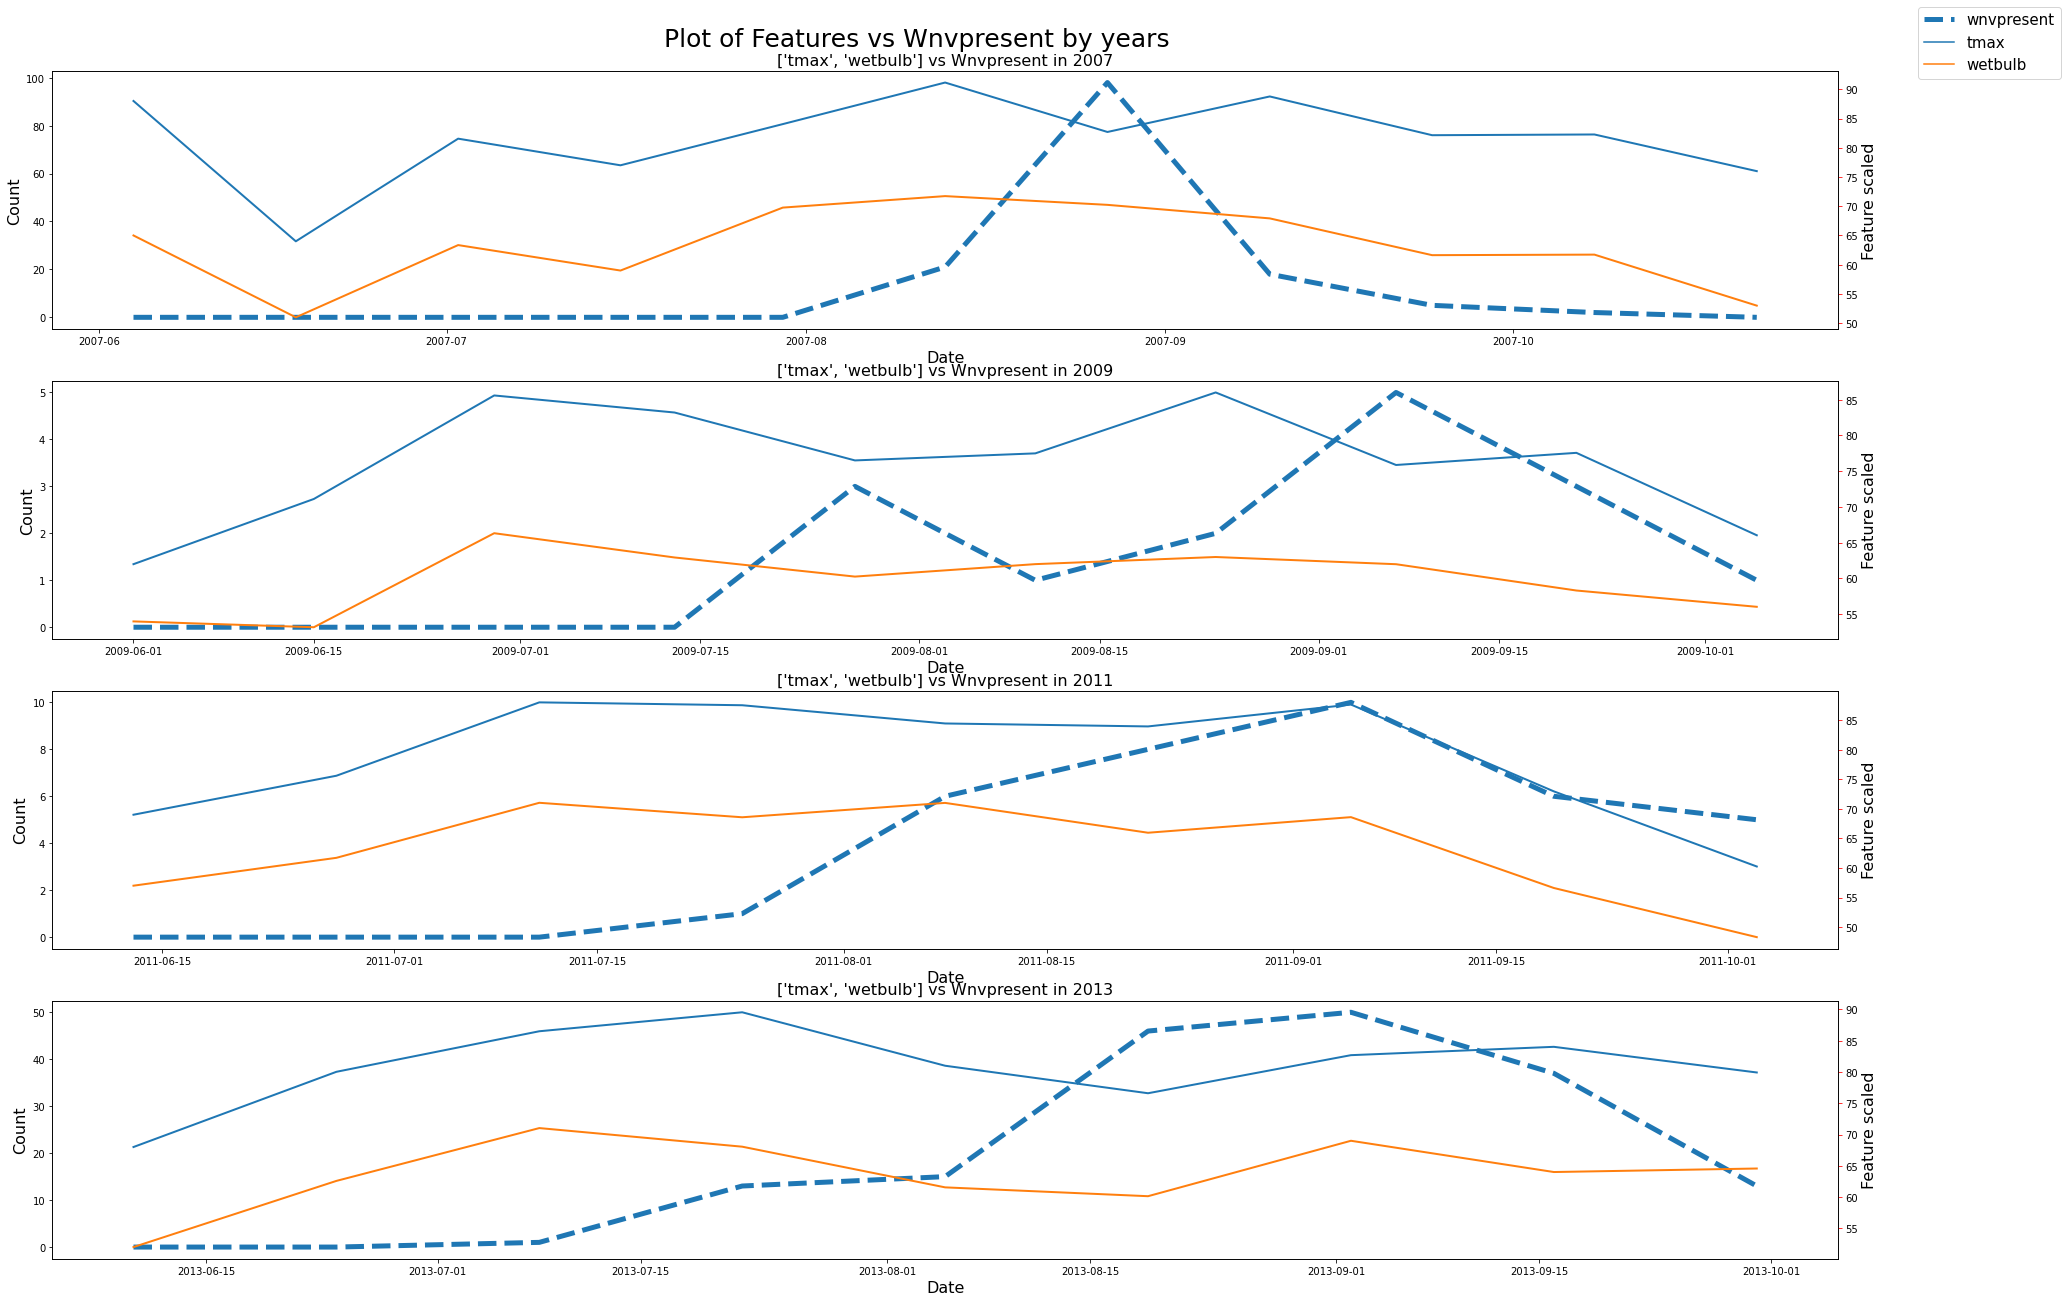

In [43]:
combi_plot(train_clean_X_plot, train_clean_y_plot, interest_col[:2], 'wnvpresent', ['mean', 'sum'], [2007, 2009, 2011, 2013], '2W-MON', (32,20))

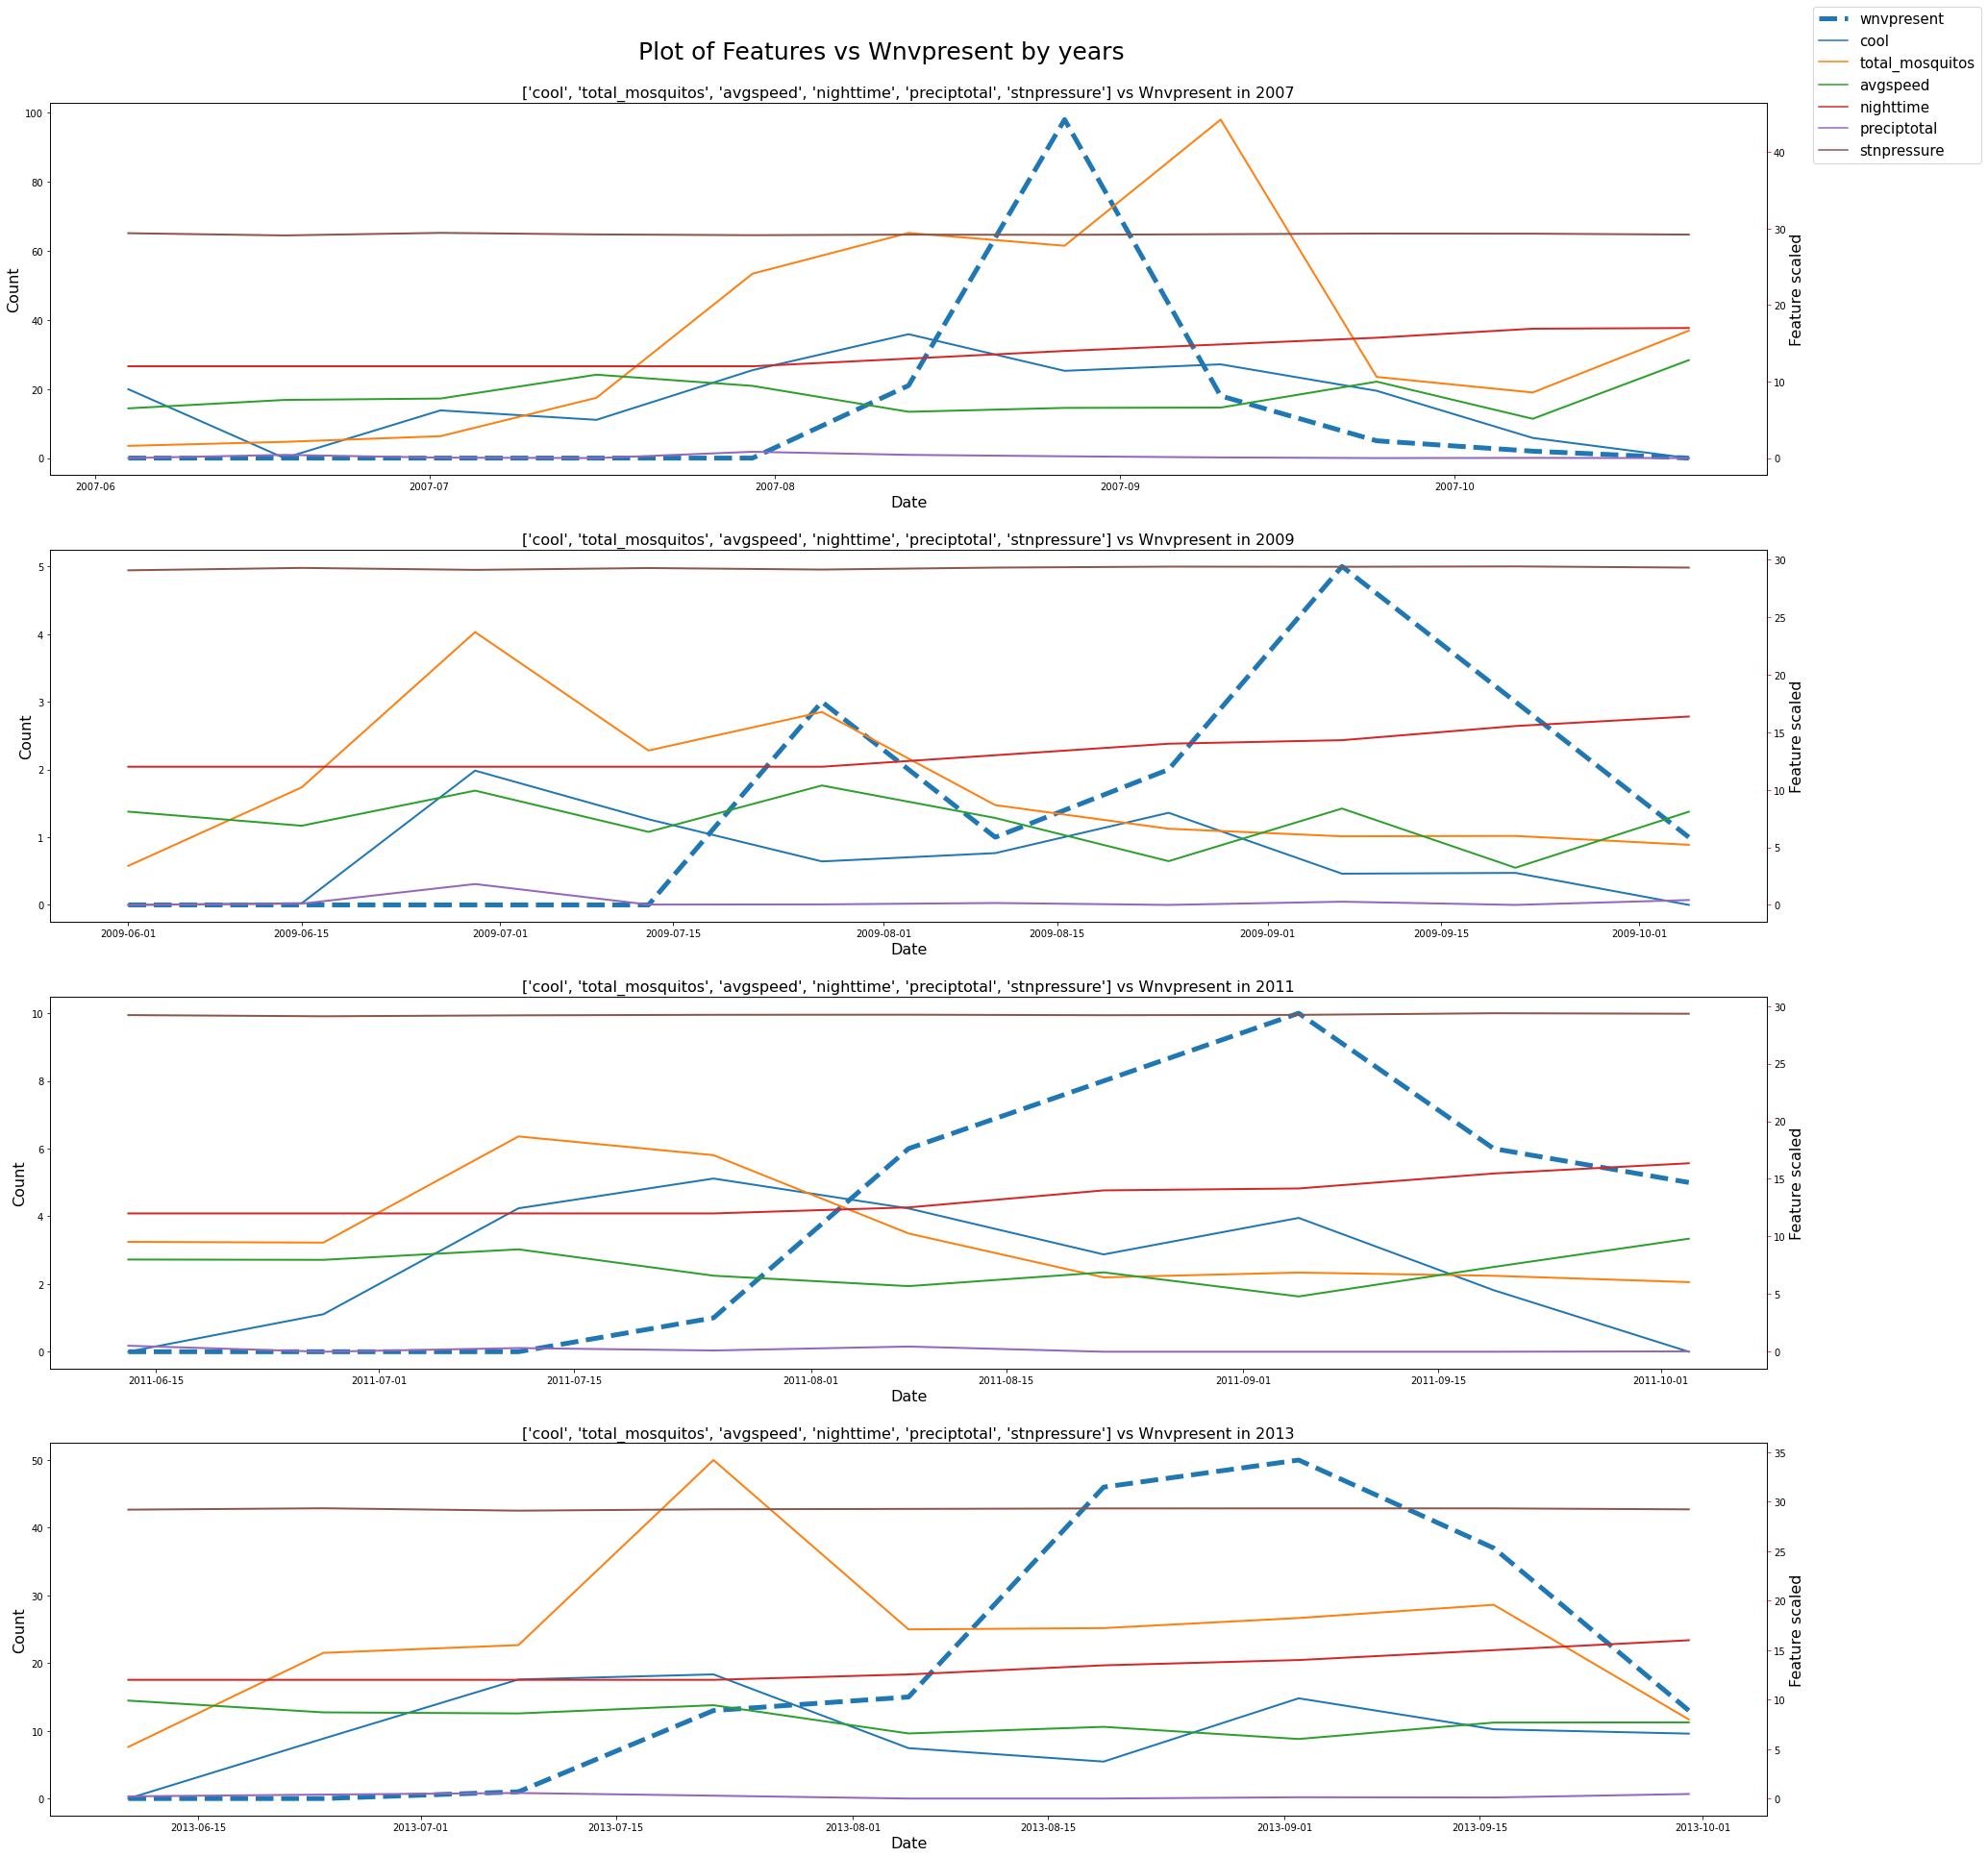

In [44]:
combi_plot(train_clean_X_plot, train_clean_y_plot, interest_col[2:], 'wnvpresent', ['mean', 'sum'], [2007, 2009, 2011, 2013], '2W-MON', (32,30))

<span style = 'color:orange'>Remark:</span> From our columns of intersts, we notice that:
- station pressure & preciptotal is irrelevant to the trend of wnvpresent.
- From the rest of the variables, although there seems to be no trends across each year with wnvpresent in our data, we do notice from external research that these factors might be a good predictor for wnvpresent. Hence we will run our modeling with these variables to see if the prediction is accurate.


## Modeling of variables of interest

### Pre-processing

In [45]:
train_clean

,species,street,trap,latitude,longitude,wnvpresent,total_mosquitos,station,tmax,tmin,...,heat,cool,codesum,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed,nighttime
date,,,,,,,,,,,,,,,,,,,,,
2007-05-29,CULEX PIPIENS/RESTUANS,N OAK PARK AVE,T002,41.954690,-87.800991,0,1,1.0,88,60,...,0.0,9.0,BR HZ,0.0,29.39,30.11,5.8,18,6.5,12
2007-05-29,CULEX RESTUANS,N OAK PARK AVE,T002,41.954690,-87.800991,0,1,1.0,88,60,...,0.0,9.0,BR HZ,0.0,29.39,30.11,5.8,18,6.5,12
2007-05-29,CULEX RESTUANS,N MANDELL AVE,T007,41.994991,-87.769279,0,1,1.0,88,60,...,0.0,9.0,BR HZ,0.0,29.39,30.11,5.8,18,6.5,12
2007-05-29,CULEX PIPIENS/RESTUANS,W FOSTER AVE,T015,41.974089,-87.824812,0,1,1.0,88,60,...,0.0,9.0,BR HZ,0.0,29.39,30.11,5.8,18,6.5,12
2007-05-29,CULEX RESTUANS,W FOSTER AVE,T015,41.974089,-87.824812,0,4,1.0,88,60,...,0.0,9.0,BR HZ,0.0,29.39,30.11,5.8,18,6.5,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-09-26,CULEX PIPIENS/RESTUANS,W 72ND ST,T035,41.763733,-87.742302,1,6,1.0,75,50,...,2.0,0.0,BR,0.0,29.34,30.04,3.8,8,4.2,16
2013-09-26,CULEX PIPIENS/RESTUANS,N RIDGE AVE,T231,41.987280,-87.666066,0,5,1.0,75,50,...,2.0,0.0,BR,0.0,29.34,30.04,3.8,8,4.2,16
2013-09-26,CULEX PIPIENS/RESTUANS,N ASHLAND AVE,T232,41.912563,-87.668055,0,1,1.0,75,50,...,2.0,0.0,BR,0.0,29.34,30.04,3.8,8,4.2,16


####  Codecum Multi-binarize (get dummies)

In [46]:
# Splitting the string
for i in range(len(train_clean['codesum'])):
    train_clean['codesum'][i] = train_clean['codesum'][i].split()

C:\Users\Sim Yi\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
train_clean['codesum']

date
2007-05-29    [BR, HZ]
2007-05-29    [BR, HZ]
2007-05-29    [BR, HZ]
2007-05-29    [BR, HZ]
2007-05-29    [BR, HZ]
                ...   
2013-09-26        [BR]
2013-09-26        [BR]
2013-09-26        [BR]
2013-09-26        [BR]
2013-09-26        [BR]
Name: codesum, Length: 8475, dtype: object

In [48]:
# Instantiate MultiLabel
mlb = MultiLabelBinarizer()

In [49]:
codesum_split = pd.DataFrame(mlb.fit_transform(train_clean['codesum']),columns='codesum_' + mlb.classes_, index=train_clean.index)

In [50]:
train_clean = pd.concat([train_clean, codesum_split], axis = 1)

In [51]:
train_clean.drop(columns = ['codesum','total_mosquitos'], inplace = True, errors = 'ignore')
train_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8475 entries, 2007-05-29 to 2013-09-26
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   species       8475 non-null   object 
 1   street        8475 non-null   object 
 2   trap          8475 non-null   object 
 3   latitude      8475 non-null   float64
 4   longitude     8475 non-null   float64
 5   wnvpresent    8475 non-null   int64  
 6   station       8475 non-null   float64
 7   tmax          8475 non-null   int64  
 8   tmin          8475 non-null   int64  
 9   tavg          8475 non-null   float64
 10  dewpoint      8475 non-null   int64  
 11  wetbulb       8475 non-null   int32  
 12  heat          8475 non-null   float64
 13  cool          8475 non-null   float64
 14  preciptotal   8475 non-null   float64
 15  stnpressure   8475 non-null   float64
 16  sealevel      8475 non-null   float64
 17  resultspeed   8475 non-null   float64
 18  resultdir 

### Ordinal encoding for species

In [52]:
species = pd.crosstab(train_clean['species'],train_clean['wnvpresent'],normalize='index')
species.reset_index(drop=True)
species.columns = ['wnvAbsent','wnvPresent']
species.sort_values(by = 'wnvPresent', ascending = False).index

Index(['CULEX PIPIENS', 'CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS',
       'CULEX ERRATICUS', 'CULEX SALINARIUS', 'CULEX TARSALIS',
       'CULEX TERRITANS'],
      dtype='object', name='species')

In [53]:
#created ordinal value for species
train_clean['species'] = train_clean['species'].map({'CULEX PIPIENS':7, 'CULEX PIPIENS/RESTUANS':6, 'CULEX RESTUANS':5,
                                         'CULEX ERRATICUS':4, 'CULEX SALINARIUS':3, 'CULEX TARSALIS':2,
                                         'CULEX TERRITANS':1 })

### One_Hot Encoding for street and trap

In [54]:
train_clean = pd.get_dummies(train_clean,columns = ['street', 'trap'])

In [55]:
train_clean.head()

,species,latitude,longitude,wnvpresent,station,tmax,tmin,tavg,dewpoint,wetbulb,...,trap_T230,trap_T231,trap_T232,trap_T233,trap_T235,trap_T236,trap_T237,trap_T238,trap_T900,trap_T903
date,,,,,,,,,,,,,,,,,,,,,
2007-05-29,6,41.954690,-87.800991,0,1.0,88,60,74.0,58,65,...,0,0,0,0,0,0,0,0,0,0
2007-05-29,5,41.954690,-87.800991,0,1.0,88,60,74.0,58,65,...,0,0,0,0,0,0,0,0,0,0
2007-05-29,5,41.994991,-87.769279,0,1.0,88,60,74.0,58,65,...,0,0,0,0,0,0,0,0,0,0
2007-05-29,6,41.974089,-87.824812,0,1.0,88,60,74.0,58,65,...,0,0,0,0,0,0,0,0,0,0
2007-05-29,5,41.974089,-87.824812,0,1.0,88,60,74.0,58,65,...,0,0,0,0,0,0,0,0,0,0


## Train Test split

In [56]:
# Set X and y
X = train_clean.drop(columns=['wnvpresent'])
y = train_clean['wnvpresent']

### Train test split

In [57]:
X.columns = X.columns.sort_values()

In [58]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42, stratify=y,test_size=0.2)

In [59]:
X_train.shape, X_test.shape

((6780, 290), (1695, 290))

In [60]:
pipe_1 = Pipeline([('sampling', SMOTE(random_state=42, k_neighbors=15)), ('RF', RandomForestClassifier(n_estimators=20) )])

pipe_2 = Pipeline([('sampling', SMOTE(random_state=42, k_neighbors=10)), 
                   ('xgb', XGBClassifier(n_estimators=200,learning_rate=0.3))])

In [61]:
pipe_1.get_params()

{'memory': None,
 'steps': [('sampling', SMOTE(k_neighbors=15, random_state=42)),
  ('RF', RandomForestClassifier(n_estimators=20))],
 'verbose': False,
 'sampling': SMOTE(k_neighbors=15, random_state=42),
 'RF': RandomForestClassifier(n_estimators=20),
 'sampling__k_neighbors': 15,
 'sampling__n_jobs': None,
 'sampling__random_state': 42,
 'sampling__sampling_strategy': 'auto',
 'RF__bootstrap': True,
 'RF__ccp_alpha': 0.0,
 'RF__class_weight': None,
 'RF__criterion': 'gini',
 'RF__max_depth': None,
 'RF__max_features': 'auto',
 'RF__max_leaf_nodes': None,
 'RF__max_samples': None,
 'RF__min_impurity_decrease': 0.0,
 'RF__min_impurity_split': None,
 'RF__min_samples_leaf': 1,
 'RF__min_samples_split': 2,
 'RF__min_weight_fraction_leaf': 0.0,
 'RF__n_estimators': 20,
 'RF__n_jobs': None,
 'RF__oob_score': False,
 'RF__random_state': None,
 'RF__verbose': 0,
 'RF__warm_start': False}

In [62]:
pipe_list = [pipe_1, pipe_2]

In [117]:
# Function to run pipeline

def run_model(pipe, pipe_params):
    
    global X_train,X_test,y_train,y_test
    
    gs = GridSearchCV(pipe,param_grid = pipe_params,scoring = 'roc_auc', cv=5, verbose = 1, n_jobs = -1)
    gs.fit(X_train,y_train)
    print(gs.best_params_)
    preds = gs.predict(X_test)
    print("MCC score: ", matthews_corrcoef(y_test,preds))
    print("Accuracy score: ", gs.score(X_test,y_test))
    plot_confusion_matrix(gs,X_test,y_test)
    plot_roc_curve(gs,X_test,y_test)

In [118]:
pipe_params_1 = {'sampling__k_neighbors': [15,20], 'RF__n_estimators': [10, 20, 30], 
                 'RF__max_leaf_nodes': [3, 4],
                'RF__max_depth': [3, 4]}

pipe_params_2 = {'sampling__k_neighbors': [15,20], 'xgb__n_estimators': [30, 40, 50], 
               'xgb__learning_rate': [0.1, 0.2, 0.3]}


In [119]:
run_model(pipe_1, pipe_params_1)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   18.3s finished


{'RF__max_depth': 3, 'RF__max_leaf_nodes': 4, 'RF__n_estimators': 10, 'sampling__k_neighbors': 20}


ValueError: Found input variables with inconsistent numbers of samples: [1695, 116293]

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.1min finished


MCC score:  0.31404348905877455
Accuracy score:  0.856023975857412


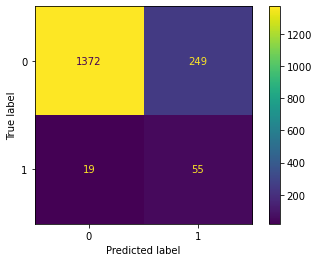

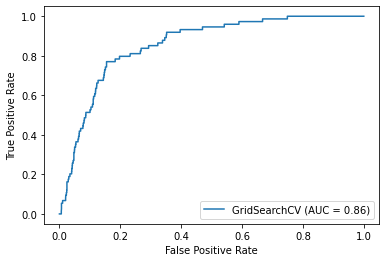

In [66]:
run_model(pipe_2, pipe_params_2)

### >>> Cost benefit

chemical used for spraying -- cost price of chemical used -- calculate by square feet

### >>>Test data cleaning and feature engineering

In [67]:
# Test data
test = pd.read_csv('datasets/test.csv')
test.columns = test.columns.str.lower()    # Convert all heading to lower
test['date'] = pd.to_datetime(test['date'])    # Convert date to datetime
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      116293 non-null  int64         
 1   date                    116293 non-null  datetime64[ns]
 2   address                 116293 non-null  object        
 3   species                 116293 non-null  object        
 4   block                   116293 non-null  int64         
 5   street                  116293 non-null  object        
 6   trap                    116293 non-null  object        
 7   addressnumberandstreet  116293 non-null  object        
 8   latitude                116293 non-null  float64       
 9   longitude               116293 non-null  float64       
 10  addressaccuracy         116293 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 9.8+ MB


In [68]:
test = pd.merge(test,weather,on = ['date'], how = 'inner')
test.head()

,id,date,address,species,block,street,trap,addressnumberandstreet,latitude,longitude,...,cool,sunrise,sunset,codesum,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,9.0,416.0,1926.0,,0.0,29.28,29.99,8.9,18,10.0
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,9.0,416.0,1926.0,,0.0,29.28,29.99,8.9,18,10.0
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,9.0,416.0,1926.0,,0.0,29.28,29.99,8.9,18,10.0
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,9.0,416.0,1926.0,,0.0,29.28,29.99,8.9,18,10.0
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,...,9.0,416.0,1926.0,,0.0,29.28,29.99,8.9,18,10.0


### Data Cleaning and Feature engineering
#### Test

In [69]:
# check null values
test.isnull().sum()

id                           0
date                         0
address                      0
species                      0
block                        0
street                       0
trap                         0
addressnumberandstreet       0
latitude                     0
longitude                    0
addressaccuracy              0
station                      0
tmax                         0
tmin                         0
tavg                         0
dewpoint                     0
wetbulb                      0
heat                         0
cool                         0
sunrise                      0
sunset                       0
codesum                      0
preciptotal               7337
stnpressure                  0
sealevel                     0
resultspeed                  0
resultdir                    0
avgspeed                     0
dtype: int64

In [70]:
test['sunrise'] = test['sunrise'].map(lambda x: changetime(x)) # make changes on sunrise 
test['sunset'] = test['sunset'].map(lambda x: changetime(x))    # make changes on sunset

In [71]:
# make sunset - sunrise = nighttime
test['nighttime'] = test['sunset'] - test['sunrise']
test['nighttime'] = test['nighttime'].map(lambda x: 24 - round(x/3600))  # round it to be only hour

In [72]:
# after convert to nighttime, drop sunset and sunrise
test.drop(columns=['sunrise','sunset'],inplace=True)

In [73]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116293 entries, 0 to 116292
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   id                      116293 non-null  int64         
 1   date                    116293 non-null  datetime64[ns]
 2   address                 116293 non-null  object        
 3   species                 116293 non-null  object        
 4   block                   116293 non-null  int64         
 5   street                  116293 non-null  object        
 6   trap                    116293 non-null  object        
 7   addressnumberandstreet  116293 non-null  object        
 8   latitude                116293 non-null  float64       
 9   longitude               116293 non-null  float64       
 10  addressaccuracy         116293 non-null  int64         
 11  station                 116293 non-null  float64       
 12  tmax                    116293

In [74]:
# change date to datetime
test['date'] = pd.to_datetime(test['date'])

####  Codecum Multi-binarize (get dummies)
##### Test

In [75]:
# Splitting the string
for i in range(len(test['codesum'])):
    test['codesum'][i] = test['codesum'][i].split()

C:\Users\Sim Yi\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [76]:
test['codesum']

0                     []
1                     []
2                     []
3                     []
4                     []
               ...      
116288    [TSRA, RA, BR]
116289    [TSRA, RA, BR]
116290    [TSRA, RA, BR]
116291    [TSRA, RA, BR]
116292    [TSRA, RA, BR]
Name: codesum, Length: 116293, dtype: object

In [77]:
codesum_split = pd.DataFrame(mlb.fit_transform(test['codesum']),columns='codesum_' + mlb.classes_, index=test.index)

test = pd.concat([test, codesum_split], axis = 1, sort=False)
test.columns

Index(['id', 'date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'station', 'tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb', 'heat',
       'cool', 'codesum', 'preciptotal', 'stnpressure', 'sealevel',
       'resultspeed', 'resultdir', 'avgspeed', 'nighttime', 'codesum_BCFG',
       'codesum_BR', 'codesum_DZ', 'codesum_FG+', 'codesum_HZ', 'codesum_RA',
       'codesum_TS', 'codesum_TSRA'],
      dtype='object')

In [78]:
#check species values
test['species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'UNSPECIFIED CULEX', 'CULEX ERRATICUS'], dtype=object)

In [79]:
#created ordinal value for species, input unseen culex as 0 as it is unknown to our train data
test['species'] = test['species'].map({'CULEX PIPIENS':7, 'CULEX PIPIENS/RESTUANS':6, 'CULEX RESTUANS':5,
                                         'CULEX ERRATICUS':4, 'CULEX SALINARIUS':3, 'CULEX TARSALIS':2,
                                         'CULEX TERRITANS':1 , 'UNSPECIFIED CULEX': 0})

In [80]:
test = pd.get_dummies(test,columns = ['street', 'trap'])

In [81]:
test.head(3)

,id,date,address,species,block,addressnumberandstreet,latitude,longitude,addressaccuracy,station,...,trap_T231,trap_T232,trap_T233,trap_T234,trap_T235,trap_T236,trap_T237,trap_T238,trap_T900,trap_T903
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",6,41,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1.0,...,0,0,0,0,0,0,0,0,0,0
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",5,41,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1.0,...,0,0,0,0,0,0,0,0,0,0
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",7,41,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,1.0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
a = test.columns.tolist()
a.remove('id')

In [100]:
set_a = set(a)
set_b = set(train_clean.columns)
print(set_a.difference(set_b))
print(' ')
print(set_b.difference(set_a))

{'trap_T200B', 'street_ W 120TH ST', 'addressnumberandstreet', 'trap_T090A', 'street_ W DAKIN ST', 'street_ N KILBOURN AVE', 'street_ N KENNETH AVE', 'street_ W 112TH ST', 'street_ W 63RD PL', 'codesum_BCFG', 'street_ E 136TH ST', 'trap_T065A', 'trap_T002A', 'trap_T218C', 'trap_T002B', 'block', 'trap_T128A', 'trap_T234', 'street_ N MELVINA AVE', 'addressaccuracy', 'trap_T218B', 'address', 'trap_T090C', 'trap_T218A', 'trap_T200A', 'codesum_FG+', 'street_ S BALTIMORE AVE', 'street_ S LOOMIS ST', 'street_ S OGLESBY AVE', 'codesum', 'date', 'trap_T090B'}
 
{'codesum_VCTS', 'codesum_FG', 'wnvpresent'}


In [106]:
list_a = list(set_a.difference(set_b))

In [107]:
test.drop(columns = list_a, inplace = True, errors = 'ignore')

test.fillna(0, inplace = True)

In [110]:
test['codesum_VCTS'] = 0
test['codesum_FG'] = 0

In [111]:
test

,id,species,latitude,longitude,station,tmax,tmin,tavg,dewpoint,wetbulb,...,trap_T232,trap_T233,trap_T235,trap_T236,trap_T237,trap_T238,trap_T900,trap_T903,codesum_VCTS,codesum_FG
0,1,6,41.954690,-87.800991,1.0,86,61,74.0,56,64.0,...,0,0,0,0,0,0,0,0,0,0
1,2,5,41.954690,-87.800991,1.0,86,61,74.0,56,64.0,...,0,0,0,0,0,0,0,0,0,0
2,3,7,41.954690,-87.800991,1.0,86,61,74.0,56,64.0,...,0,0,0,0,0,0,0,0,0,0
3,4,3,41.954690,-87.800991,1.0,86,61,74.0,56,64.0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,41.954690,-87.800991,1.0,86,61,74.0,56,64.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116288,116289,3,41.925652,-87.633590,1.0,72,63,68.0,61,63.0,...,0,0,0,0,0,0,0,0,0,0
116289,116290,1,41.925652,-87.633590,1.0,72,63,68.0,61,63.0,...,0,0,0,0,0,0,0,0,0,0
116290,116291,2,41.925652,-87.633590,1.0,72,63,68.0,61,63.0,...,0,0,0,0,0,0,0,0,0,0
116291,116292,0,41.925652,-87.633590,1.0,72,63,68.0,61,63.0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
train_clean

,species,latitude,longitude,wnvpresent,station,tmax,tmin,tavg,dewpoint,wetbulb,...,trap_T230,trap_T231,trap_T232,trap_T233,trap_T235,trap_T236,trap_T237,trap_T238,trap_T900,trap_T903
date,,,,,,,,,,,,,,,,,,,,,
2007-05-29,6,41.954690,-87.800991,0,1.0,88,60,74.0,58,65,...,0,0,0,0,0,0,0,0,0,0
2007-05-29,5,41.954690,-87.800991,0,1.0,88,60,74.0,58,65,...,0,0,0,0,0,0,0,0,0,0
2007-05-29,5,41.994991,-87.769279,0,1.0,88,60,74.0,58,65,...,0,0,0,0,0,0,0,0,0,0
2007-05-29,6,41.974089,-87.824812,0,1.0,88,60,74.0,58,65,...,0,0,0,0,0,0,0,0,0,0
2007-05-29,5,41.974089,-87.824812,0,1.0,88,60,74.0,58,65,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-09-26,6,41.763733,-87.742302,1,1.0,75,50,63.0,52,58,...,0,0,0,0,0,0,0,0,0,0
2013-09-26,6,41.987280,-87.666066,0,1.0,75,50,63.0,52,58,...,0,1,0,0,0,0,0,0,0,0
2013-09-26,6,41.912563,-87.668055,0,1.0,75,50,63.0,52,58,...,0,0,1,0,0,0,0,0,0,0


In [112]:
X = train_clean.drop('wnvpresent', axis =1)
y = train_clean['wnvpresent']
X_test = test.drop('id', axis =1)

In [120]:
# create predictions and submission file

best_gs = Pipeline([('sampling', SMOTE(random_state=42, k_neighbors=20)), 
                    ('RF', RandomForestClassifier(n_estimators=10, max_depth = 3, max_leaf_nodes = 4))])





best_gs.fit(X, y)
predictions = best_gs.predict_proba(X_test)[:,1]

In [121]:
test['WnvPresent'] = predictions

In [122]:
testing_submission = test[['id', 'WnvPresent']]
testing_submission.columns = ['Id', 'WnvPresent']

In [123]:
testing_submission.to_csv('testing_submission.csv', index=False)

### Conclusion